Here, we create a multiclass classifier for classifying the various closest vectors returned by the model, as the corresponding attributes.

In [1]:
import warnings
warnings.filterwarnings('ignore')

from gensim.models.wrappers import FastText
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

import pandas as pd
import numpy as np
import h5py
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from keras.preprocessing import sequence
from keras import models
from keras import layers
from keras import activations
from keras import optimizers
from keras import losses
from keras import metrics
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import keras.preprocessing.text
from keras.models import load_model
from keras.utils import np_utils

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


## Prepare Dataset

In [2]:
#df = pd.read_csv('truthvalue.csv', encoding='utf8', dtype=object)

In [3]:
df = pd.read_csv('AdultTrainingDataMultiAttributes.csv', dtype=object)

In [4]:
df.shape

(32537, 12)

In [5]:
df = df.apply(lambda x: x.astype(str).str.lower())

In [6]:
df.columns.values

array(['age', 'workclass', 'education', 'educationnum', 'maritalstatus',
       'occupation', 'relationship', 'race', 'sex', 'hoursperweek',
       'country', 'income'], dtype=object)

## Data Cleaning

In [7]:
#df['ProviderNumber'] = df['ProviderNumber'].apply(lambda x: str(int(float(x))))
#df['ZipCode'] = df['ZipCode'].apply(lambda x: str(int(float(x))))
#df['PhoneNumber'] = df['PhoneNumber'].apply(lambda x: str(int(float(x))))

In [8]:
df.head(2)

,age,workclass,education,educationnum,maritalstatus,occupation,relationship,race,sex,hoursperweek,country,income
0,50,private,hs-grad,9,married-spouse-absent,exec-managxrial,not-in-family,white,female,55,united-states,<=50k
1,45,self-emp-not-inc,some-college,10,married-civ-spouse,exec-managerial,husband,white,male,60,united-states,<=50k


In [9]:
df.shape

(32537, 12)

In [10]:
values = []
for i in df.columns:
    values.append(df[i].tolist())

In [11]:
attributes = df.columns.tolist()

Create value, attribute-name tuple pairs

In [12]:
data = []
for i in range(len(values)):
    for value in values[i]:
        data.append([value, attributes[i]])

In [13]:
len(data)

390444

In [14]:
data[:10]

[['50', 'age'],
 ['45', 'age'],
 ['34', 'age'],
 ['x4', 'age'],
 ['63', 'age'],
 ['63', 'age'],
 ['39', 'age'],
 ['77', 'age'],
 ['31', 'age'],
 ['32', 'age']]

In [15]:
data[-10:]

[['>50k', 'income'],
 ['<=50k', 'income'],
 ['<=50k', 'income'],
 ['>50k', 'income'],
 ['<=50k', 'income'],
 ['<=50k', 'income'],
 ['<=50k', 'income'],
 ['<=50k', 'income'],
 ['<=50k', 'income'],
 ['<=50k', 'income']]

In [16]:
dfData = pd.DataFrame(data, columns=['Value','Label'])

In [17]:
dfData.head(2)

,Value,Label
0,50,age
1,45,age


In [18]:
dfData.tail()

,Value,Label
390439,<=50k,income
390440,<=50k,income
390441,<=50k,income
390442,<=50k,income
390443,<=50k,income


Convert labels to categorical attributes

In [19]:
dfData['Label'] = dfData['Label'].astype('category')

In [20]:
dfData["Label_Cat"] = dfData["Label"].cat.codes

In [21]:
dfData.tail()

,Value,Label,Label_Cat
390439,<=50k,income,5
390440,<=50k,income,5
390441,<=50k,income,5
390442,<=50k,income,5
390443,<=50k,income,5


In [22]:
dfData['Label_Cat'].value_counts()

11    32537
10    32537
9     32537
8     32537
7     32537
6     32537
5     32537
4     32537
3     32537
2     32537
1     32537
0     32537
Name: Label_Cat, dtype: int64

Get the mapping

In [23]:
mapping = dict(enumerate(dfData['Label'].cat.categories))

In [24]:
mapping

{0: 'age',
 1: 'country',
 2: 'education',
 3: 'educationnum',
 4: 'hoursperweek',
 5: 'income',
 6: 'maritalstatus',
 7: 'occupation',
 8: 'race',
 9: 'relationship',
 10: 'sex',
 11: 'workclass'}

Drop the Label column

In [25]:
dfData.drop(['Label'], axis=1, inplace=True)

In [26]:
dfData.head()

,Value,Label_Cat
0,50,0
1,45,0
2,34,0
3,x4,0
4,63,0


Shuffle the data

In [27]:
dfData = dfData.sample(frac=1).reset_index(drop=True)

In [28]:
dfData.head(10)

,Value,Label_Cat
0,husband,9
1,>50k,5
2,13,3
3,united-states,1
4,private,11
5,40,4
6,married-civ-spouse,6
7,20,0
8,9,3
9,husband,9


Find the longest string in the value column

In [29]:
maxLength = dfData.Value.map(lambda x: len(str(x))).max()

In [30]:
maxLength

26

In [31]:
X = dfData['Value'].tolist()
y = dfData['Label_Cat'].tolist()

## Tokenize and obtain the train, test split

In [32]:
batchSize = 32
maxSequenceLength = maxLength
maxWords = 2 * sum(dfData.nunique())

In [33]:
tokenizer = Tokenizer(num_words=maxWords)
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 763 unique tokens.


In [34]:
data = pad_sequences(sequences, maxlen=maxSequenceLength)

In [35]:
labels = np.asarray(y)

In [36]:
data.shape

(390444, 26)

In [37]:
labels.shape

(390444,)

In [38]:
labels = to_categorical(labels)

In [39]:
labels.shape

(390444, 12)

Shuffle the dataset

In [40]:
indices = np.arange(data.shape[0])
#np.random.shuffle(indices)

In [41]:
data = data[indices]
labels = labels[indices]

## Train test split

In [42]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=22, stratify=labels)

In [43]:
len(X_train), len(y_train)

(195222, 195222)

In [44]:
len(X_test), len(y_test)

(195222, 195222)

## Model

In [45]:
embeddingDim = 100

**Architecture**
* 1 embedding layer 
* 1 dense layer, 32 hidden units and _relu_ activation
* 1 dense layer, 64 hidden units and _relu_ activation
* Output layer, _softmax_ activation

In [46]:
model = models.Sequential()
model.add(layers.Embedding(maxWords, embeddingDim, input_length=maxSequenceLength))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation=activations.relu))
model.add(layers.Dense(64, activation=activations.relu))
model.add(layers.Dense(labels.shape[1], activation=activations.softmax))

model.compile(optimizer=optimizers.Adam(), loss=losses.categorical_crossentropy, metrics=['accuracy'])

In [47]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 26, 100)           158000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2600)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                83232     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                780       
Total params: 244,124
Trainable params: 244,124
Non-trainable params: 0
_________________________________________________________________


In [48]:
history = model.fit(X_train, y_train,
                    epochs=3,
                    batch_size=32, 
                    validation_split=0.5)

Train on 97611 samples, validate on 97611 samples
Epoch 1/3
97611/97611 [==============================] - 10s 103us/step - loss: 0.2308 - acc: 0.9233 - val_loss: 0.1145 - val_acc: 0.9533
Epoch 2/3
97611/97611 [==============================] - 10s 101us/step - loss: 0.1137 - acc: 0.9525 - val_loss: 0.1122 - val_acc: 0.9537
Epoch 3/3
97611/97611 [==============================] - 10s 100us/step - loss: 0.1112 - acc: 0.9533 - val_loss: 0.1104 - val_acc: 0.9539


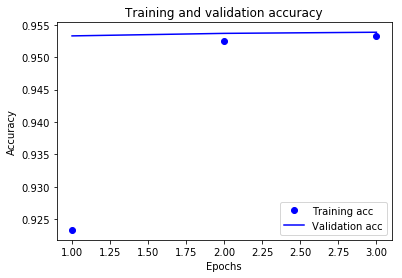

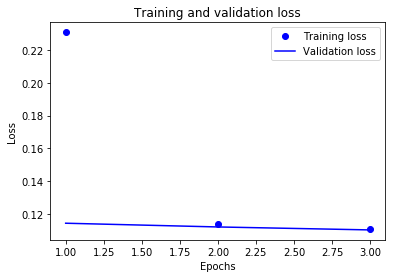

In [49]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show();

In [50]:
results = model.evaluate(X_test, y_test)

195222/195222 [==============================] - 4s 23us/step


In [51]:
loss = results[0]
accuracy = results[1]

In [52]:
loss

0.11076401892018155

In [53]:
accuracy

0.953150771939855

Save the model

In [54]:
model.save("AdultMultiAttributeClassifier.h5")

Save the tokenizer

In [55]:
with open('AdultMultiAttributeClassifierTokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL) # fix_imports=True)

## Make predictions on new data

In [56]:
model = load_model('AdultMultiAttributeClassifier.h5')

In [57]:
with open('AdultMultiAttributeClassifierTokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [58]:
testString = ['whitx']

In [59]:
sequences = tokenizer.texts_to_sequences(testString)
testData = pad_sequences(sequences, maxlen=maxLength)

In [60]:
predictions = model.predict(testData)

In [61]:
#mapping = dict(enumerate(df.columns.astype('category').categories))

In [62]:
mapping[np.argmax(predictions[0])]

'race'